Content based filtering using TF_IDF and Cosine similarity

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
#from movies_recommendation_content_2 import get_cosine_sim3, get_cosine_sim2, jaccard_set
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
import json
import ast
from ast import literal_eval


Data exploration

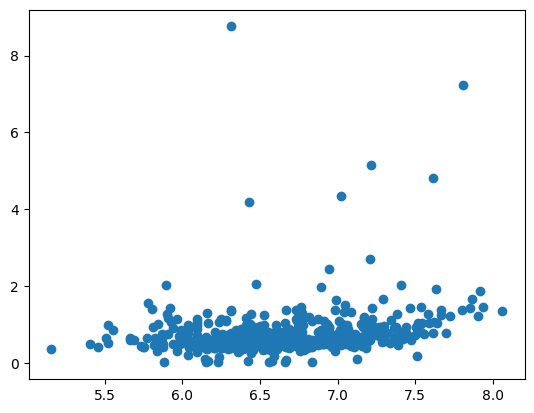

In [61]:
path = kagglehub.dataset_download("tmdb/tmdb-movie-metadata")

movies = pd.read_csv("./../data/tmdb_5000_movies.csv")
credits = pd.read_csv("./../data/tmdb_5000_credits.csv")

#Data exploration
C= movies['vote_average'].mean()
m= movies['vote_count'].quantile(0.9)
q_movies = movies.copy().loc[movies['vote_count'] >= m]
q_movies = q_movies.copy().loc[q_movies['original_language']=='en']
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
q_movies = q_movies.sort_values('score', ascending=False)
plt.scatter(q_movies['score'],q_movies['popularity']/100)
plt.show()

Data preprocessing: identifying which features to be used

In [62]:
movies=movies.merge(credits,on='title')
movies_sel=movies[[ 'id','genres', 'keywords', 'title', 'overview', 'cast', 'crew','vote_average']]
movies_sel['title_lower']=movies_sel['title'].apply(lambda x: x.lower())
movies_sel['english_language']=movies['original_language']=='en'
movies.dropna(inplace=True)
movies_sel['overview']=movies_sel['overview'].fillna('')
movies_sel['year']=movies['release_date'][0][0:4]
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    movies_sel[feature] = movies_sel[feature].apply(literal_eval)

Extracting features like cast, director, keywords, and genre.

In [63]:

def convert5(obj):
    tags=[]
    iterator=0
    for i in ast.literal_eval(obj):
        if iterator!=5:   #top Five in the cast
            tags.append(i["name"])
            iterator+=1
        else:
            break
    return tags

def convert(obj):
    tags=[]
    for i in ast.literal_eval(obj): 
        tags.append(i["name"])
    return tags
def director(obj): #director extraction from crew
    tags=[]
    for i in ast.literal_eval(obj):
        if i['job']=='Director':   #Taking the first Director name even in case of multiple
            tags.append(i["name"]) 
            break
    return tags

def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

movies_sel['crew']=movies['crew'].apply(director)
movies_sel['cast']=movies['cast'].apply(convert5)
movies_sel['genres']=movies['genres'].apply(convert)

movies_sel['keywords']=movies['keywords'].apply(convert)
movies_sel['production_companies']=movies['production_companies'].apply(convert)

features = ['cast',  'crew', 'genres','keywords','production_companies']
for feature in features:
    movies_sel[feature] = movies_sel[feature].apply(clean_data)


movies_sel["combo_list"] =   movies_sel["genres"]+ movies_sel["keywords"]+ movies_sel["cast"]+ movies_sel["crew"]
# we have experiemented using 'production_companies' as well, but it does not give good results.

movies_sel["combo_list"] =movies_sel["combo_list"].apply(lambda x: " ".join((x)))

movies_sel["combo_list"] =movies_sel["combo_list"].apply(lambda x: x.lower())


movies_sel['combo_list']=movies_sel['combo_list'].fillna('')


Vectorization using TF-IDF and cosine similarity
Cosine similarity computes angle between two vector
cos(theta)= |A.B|/(||A||.||B||)

In [64]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_sel['overview'])
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

indices = pd.Series(movies_sel.index, index=movies_sel['title']).drop_duplicates()
indices_lower = pd.Series(movies_sel.index, index=movies_sel['title_lower']).drop_duplicates()

tfidf_matrix_new = tfidf.fit_transform(movies_sel["combo_list"])


# Compute the cosine similarity matrix
cosine_sim2 = linear_kernel(tfidf_matrix_new, tfidf_matrix_new)

Function for getting recommended movies.

In [65]:
def get_recommendations(title,len_recommended_movies , cosine_sim2):
        
    idx = indices_lower[title]
    sim_scores = list(enumerate(cosine_sim2[idx]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:len_recommended_movies+1]
    movie_indices = [i[0] for i in sim_scores]
    tags=[]
    for i in range(len_recommended_movies):
        tags.append(movies_sel['title'].iloc[movie_indices[i]])
    # Return the topmost similar movies
    movies_recommended= movies_sel['title'].iloc[movie_indices]
    
    sim_scores_val= 10*np.log10([i[1] for i in sim_scores])
    plt.bar(tags,sim_scores_val)
    plt.xlabel("Movie names")
    plt.ylabel("10log(Similarity scores)")
    plt.title(f"Similarity scores for movie : %s" %str(title).capitalize())
    plt.show()
    return     tags

Function for getting a standard set of recommendations from tastedive.com

In [66]:
def get_movies_from_tastedive(movie_name,num_recommended_movies):      
    dest_url = "https://tastedive.com/api/similar"
   
    dp = {'q': movie_name, 'type': 'movie', 'k':'1039874-Moviepro-A6E10BE0','limit':2*num_recommended_movies}
    resp = requests.get(dest_url, params = dp)
    recommendation = resp.json()
    similar=recommendation['similar']
    
    tags=[]
    for i in range(2*num_recommended_movies):
        
        if similar['results'][i]['name'] in list(movies_sel['title']):
            tags.append((similar['results'][i]['name']))
        
    if (len(tags)) > num_recommended_movies:
        return tags[0:num_recommended_movies]
    else:
        return tags

Final code for comparison

Thank You


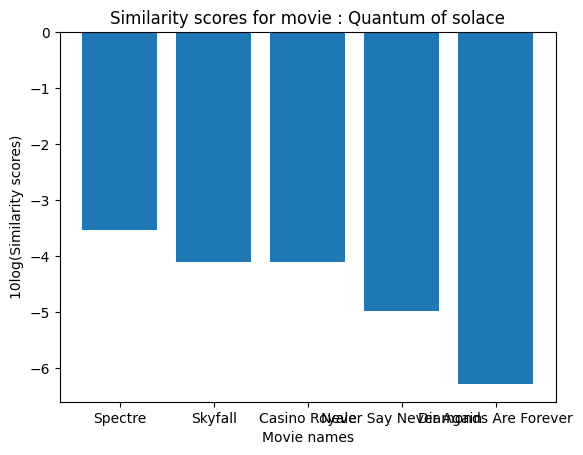

Quantum of Solace
['Casino Royale', 'The World Is Not Enough', 'Die Another Day', 'Skyfall', 'Tomorrow Never Dies', 'GoldenEye', 'Spectre', 'Diamonds Are Forever', 'Thunderball', 'A View to a Kill']
['Spectre', 'Skyfall', 'Casino Royale', 'Never Say Never Again', 'Diamonds Are Forever']
Thank You


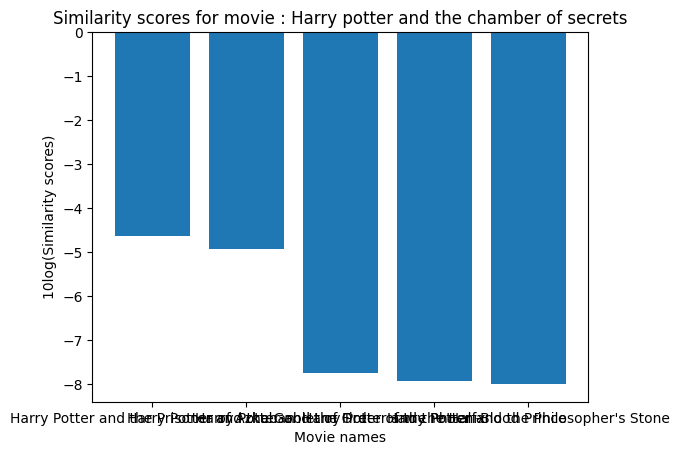

Harry Potter and the chamber of secrets
['Spider-Man', 'Spider-Man 2', 'Harry Potter and the Order of the Phoenix', 'Iron Man', 'Spider-Man 3', 'Harry Potter and the Half-Blood Prince', 'Avatar', 'Captain America: The Winter Soldier']
['Harry Potter and the Prisoner of Azkaban', 'Harry Potter and the Goblet of Fire', 'Harry Potter and the Order of the Phoenix', 'Harry Potter and the Half-Blood Prince', "Harry Potter and the Philosopher's Stone"]
Thank You


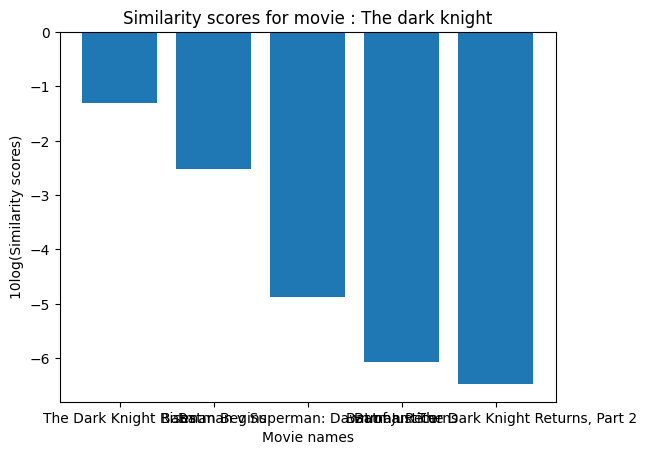

The Dark knight
['Inception', 'The Matrix', 'Guardians of the Galaxy', 'Terminator 2: Judgment Day', 'Captain America: The Winter Soldier', 'The Avengers', 'Iron Man', 'V for Vendetta', 'Iron Man 3', 'Interstellar']
['The Dark Knight Rises', 'Batman Begins', 'Batman v Superman: Dawn of Justice', 'Batman Returns', 'Batman: The Dark Knight Returns, Part 2']
Thank You


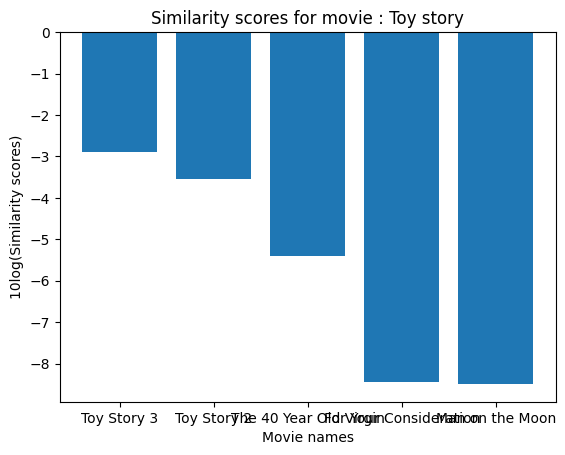

Toy Story
['Toy Story 2', 'Toy Story 3', 'Monsters, Inc.', 'Ratatouille', 'Up', 'Finding Nemo', 'How to Train Your Dragon', 'Aladdin', 'Inside Out', 'Shrek']
['Toy Story 3', 'Toy Story 2', 'The 40 Year Old Virgin', 'For Your Consideration', 'Man on the Moon']
Thank You


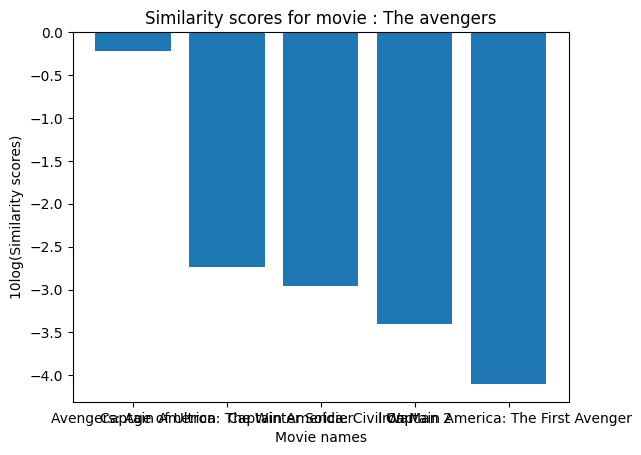

The Avengers
['Indiana Jones and the Kingdom of the Crystal Skull', 'Superman', 'Star Trek', 'Goldfinger', 'You Only Live Twice', 'Dr. No', 'Batman', 'Indiana Jones and the Temple of Doom', 'Captain America: The First Avenger', 'Superman Returns']
['Avengers: Age of Ultron', 'Captain America: The Winter Soldier', 'Captain America: Civil War', 'Iron Man 2', 'Captain America: The First Avenger']
Thank You


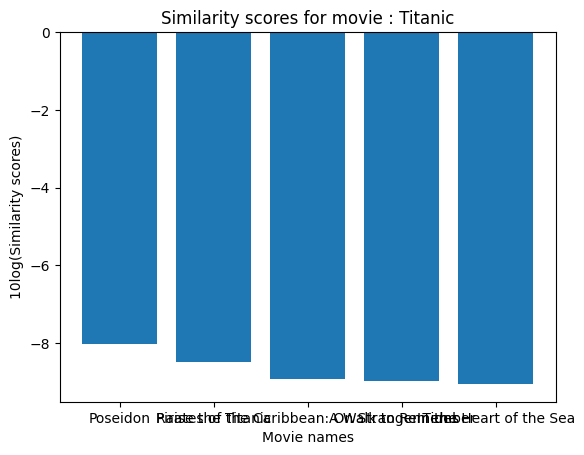

Titanic
['Inception', 'Avatar', 'I Am Legend', 'Spider-Man', 'The Hunger Games', 'V for Vendetta', 'Spider-Man 2', 'The Day After Tomorrow', 'The Hunger Games: Catching Fire', 'The Amazing Spider-Man']
['Poseidon', 'Raise the Titanic', 'Pirates of the Caribbean: On Stranger Tides', 'A Walk to Remember', 'In the Heart of the Sea']
Thank You


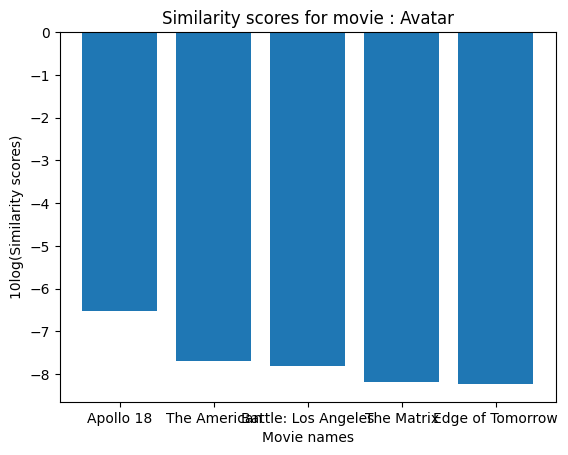

Avatar
['I Am Legend', 'Zombieland', 'The Twilight Saga: Eclipse', 'The Hunt', 'Hancock', 'Hellboy', 'Piranha 3D', 'Transformers', 'Spider-Man', 'Daybreakers']
['Apollo 18', 'The American', 'Battle: Los Angeles', 'The Matrix', 'Edge of Tomorrow']
Thank You


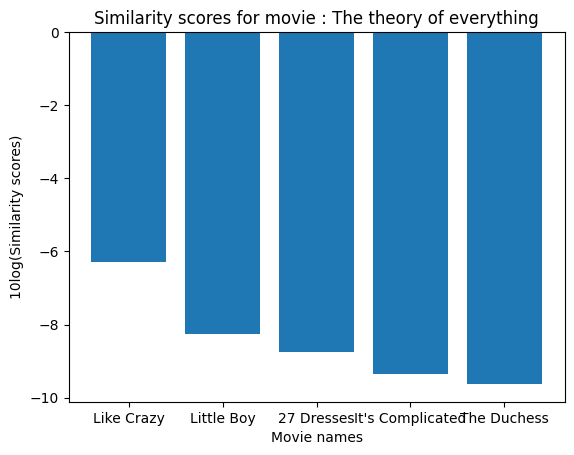

The Theory of Everything
['The Imitation Game', 'Steve Jobs', 'Dallas Buyers Club', 'Big Eyes', 'Brooklyn', 'Joy', 'Selma', 'Woman in Gold', 'Philomena', 'The Social Network']
['Like Crazy', 'Little Boy', '27 Dresses', "It's Complicated", 'The Duchess']
Thank You


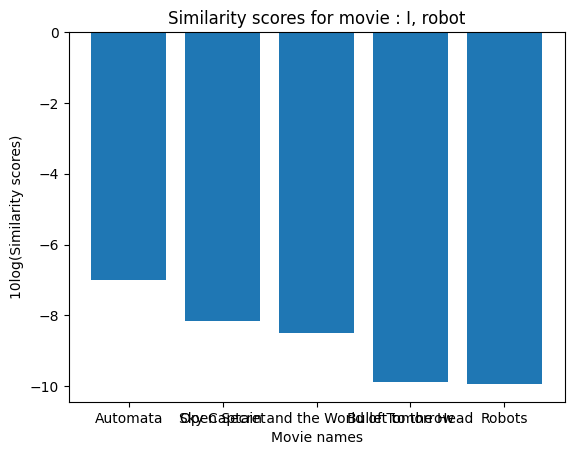

I, Robot
['The X Files: I Want to Believe', 'Disturbia', 'Unbreakable', 'Signs', 'The Skeleton Key', 'I Am Legend', 'The Hunted', 'The Cell', 'The Cabin in the Woods', 'White Noise']
['Automata', 'Open Secret', 'Sky Captain and the World of Tomorrow', 'Bullet to the Head', 'Robots']
Thank You


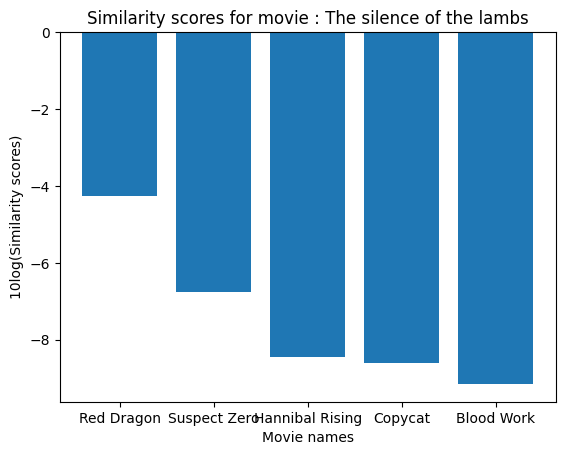

The Silence of the Lambs
['No Country for Old Men', 'The Departed', 'Taxi Driver', 'Se7en', 'Reservoir Dogs', 'The Usual Suspects', 'American History X', 'Sin City', 'Red Dragon', 'Memento']
['Red Dragon', 'Suspect Zero', 'Hannibal Rising', 'Copycat', 'Blood Work']
0.08421578421578421


In [ ]:
def jaccard_set(list1, list2):
    """Define Jaccard Similarity function for two sets"""
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union
def recommended_movies():
    Accuracy=[]
    #movie_name=input('Suggest a English movie name: ')
    num_recommended_movies=5
    for movie_name in ['Quantum of Solace', 'Harry Potter and the chamber of secrets','The Dark knight','Toy Story','The Avengers','Titanic','Avatar','The Theory of Everything','I, Robot', 'The Silence of the Lambs' ]:
        if not movie_name:
            print('Model Recommendation')
            print((q_movies[['title']].head(10)))
        else:
            if movie_name.lower() in list(movies_sel['title_lower']):
                print('Thank You')
            else:
                print('Sorry, we do not have this in our database.')
                return 
            Benchmark_recommendation = get_movies_from_tastedive(movie_name.lower(),2*num_recommended_movies)

            
            Model_recommendation3=get_recommendations(movie_name.lower(),num_recommended_movies,cosine_sim+cosine_sim2)
            #print(movie_name)
            #print(Benchmark_recommendation)
            #print(Model_recommendation3)

            Accuracy.append(jaccard_set(Benchmark_recommendation,Model_recommendation3))
            
    #print(np.mean(Accuracy))
            
recommended_movies()